In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


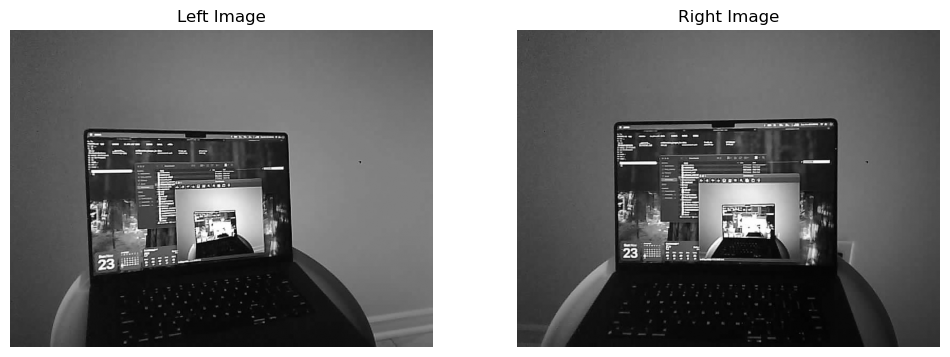

In [ ]:
# Stereo images
LEFT_PATH = "./stereo/left.jpg"
RIGHT_PATH = "./stereo/right.jpg"

imgL = cv2.imread(LEFT_PATH, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(RIGHT_PATH, cv2.IMREAD_GRAYSCALE)

if imgL is None or imgR is None:
    raise FileNotFoundError("Could not load stereo images.")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(imgL, cmap='gray'); plt.title("Left Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(imgR, cmap='gray'); plt.title("Right Image"); plt.axis("off")
plt.show()


In [16]:
sift = cv2.SIFT_create()

kpsL, desL = sift.detectAndCompute(imgL, None)
kpsR, desR = sift.detectAndCompute(imgR, None)

print("Left keypoints:", len(kpsL))
print("Right keypoints:", len(kpsR))

Left keypoints: 1273
Right keypoints: 1402


In [17]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(desL, desR, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

print("Good matches:", len(good))


Good matches: 339


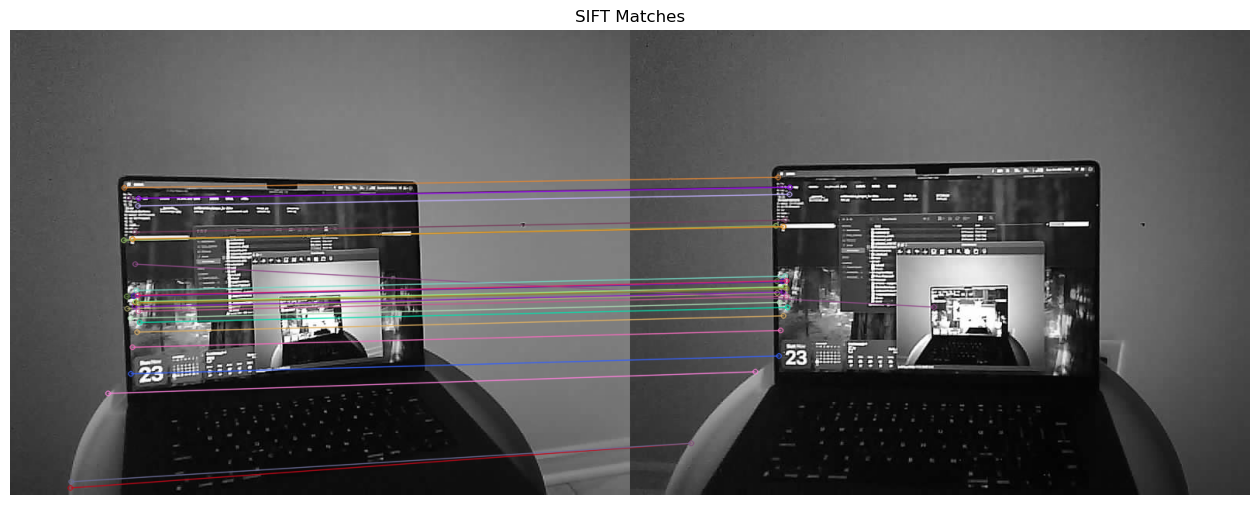

In [18]:
match_img = cv2.drawMatches(imgL, kpsL, imgR, kpsR, good[:30], None, flags=2)

plt.figure(figsize=(16,8))
plt.imshow(match_img)
plt.title("SIFT Matches")
plt.axis("off")
plt.show()


In [19]:
ptsL = np.float32([kpsL[m.queryIdx].pt for m in good])
ptsR = np.float32([kpsR[m.trainIdx].pt for m in good])


In [20]:
focal = 700
cx, cy = imgL.shape[1]//2, imgL.shape[0]//2
K = np.array([[focal, 0, cx],
              [0, focal, cy],
              [0,     0,   1]], dtype=float)

E, mask = cv2.findEssentialMat(ptsL, ptsR, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

print("Essential matrix:\n", E)


Essential matrix:
 [[-0.02293945 -0.70452308 -0.00384802]
 [ 0.70120363 -0.02223714  0.08738141]
 [ 0.01166211 -0.05614063  0.00137505]]


In [21]:
points, R, t, mask_pose = cv2.recoverPose(E, ptsL, ptsR, K)

print("Rotation:\n", R)
print("Translation:\n", t)


Rotation:
 [[ 0.99845017 -0.03275554  0.04499266]
 [ 0.03340402  0.99934751 -0.0137374 ]
 [-0.04451333  0.01521905  0.99889286]]
Translation:
 [[ 0.07881883]
 [ 0.01915527]
 [-0.9967049 ]]


In [22]:
# Projection matrices
P1 = np.hstack((np.eye(3), np.zeros((3,1))))
P2 = np.hstack((R, t))

# Convert to camera coordinate system
P1 = K @ P1
P2 = K @ P2

pts4D = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)
pts3D = pts4D[:3] / pts4D[3]  # convert from homogeneous

Z = pts3D[2]         # depth values


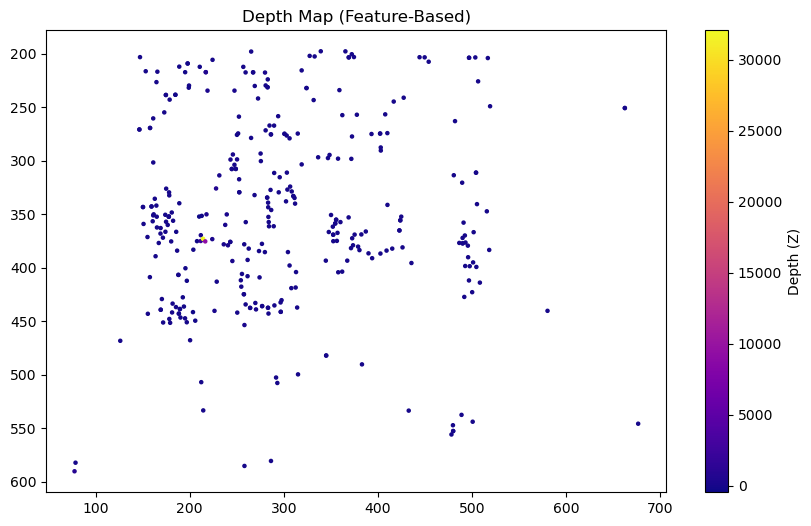

In [23]:
plt.figure(figsize=(10,6))
plt.scatter(ptsL[:,0], ptsL[:,1], c=Z, cmap='plasma', s=5)
plt.title("Depth Map (Feature-Based)")
plt.gca().invert_yaxis()
plt.colorbar(label="Depth (Z)")
plt.show()


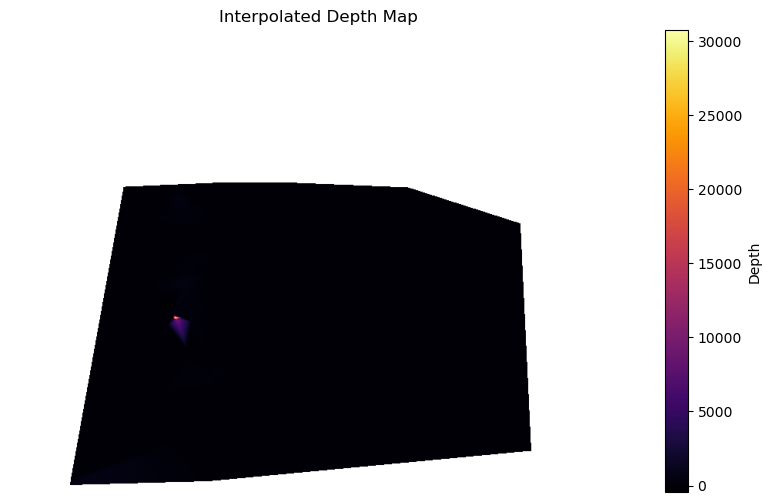

In [24]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:imgL.shape[1], 0:imgL.shape[0]]
depth_grid = griddata(ptsL, Z, (grid_x, grid_y), method='linear')

plt.figure(figsize=(10,6))
plt.imshow(depth_grid.T, cmap='inferno')
plt.title("Interpolated Depth Map")
plt.axis("off")
plt.colorbar(label="Depth")
plt.show()
